## Shape protrusion distance
The protrusion distance refers to the proportion of the smaller molecule that protrudes from the larger molecule (therefore, we can work out the overlap between the two molecules).

I found when running this that the amount of protrusion depends on the protein file used. When I looked at the overlap between the fragment and the proteins - the amount they overlapped with the different proteins also varied.

Possible workflow:
For each merge - get the protein file for each original fragment (so we have protein A and protein B)
Calculate the protrusion distance between the merge and each protein
Take the geometric mean of the two distances

Either:
Use a 5% overlap cut-off (i.e. if the overlap (using the calculated mean) of the merge with the protein is >5%, then do not use these merges, as the minimisation will not be able to compensate for big overlaps).
Calculate the protrusion distance of the fragments with the proteins and proportionally get the 5% cut-off

## Imports

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem, DataStructs
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(1, '/home/sabsr3/xchem/fragment_network_merges/scripts')
from OverlapFilter import *

## Filter

Playing around with the data first to find the best way to filter

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCN(Cc2ccncc2)CC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CC1CCNc2cc3c(cc21)OCCO3,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C2CCC1CC(=C1CCC1)C2,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCCC2(CCCCCC2)C1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,

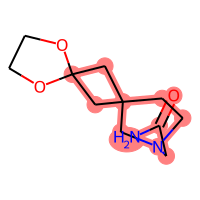
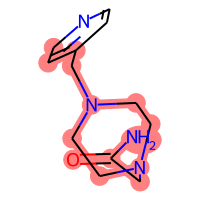
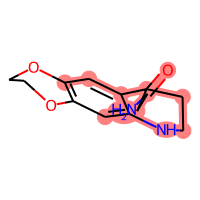
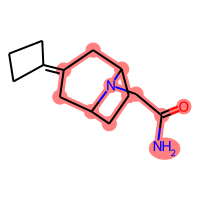
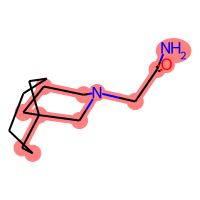

In [2]:
PandasTools.RenderImagesInAllDataFrames(images=True)  # line needed to render the rdkit images in the saved csv
df = pd.read_csv('/home/sabsr3/xchem/fragment_network_merges/data/filtered/embeddedFiltered.csv')
df.head()

In [3]:
# get filepaths of proteins
path = '/home/sabsr3/xchem/fragment_network_merges/data/Mpro/aligned/Mpro-FRAG_0A/Mpro-FRAG_0A_apo-desolv.pdb'

def get_filepaths(frag):
    return path.replace('FRAG', frag)

df['Fragment A protein file'] = df.apply(lambda x: get_filepaths(x['Fragment A ID']), axis=1)
df['Fragment B protein file'] = df.apply(lambda x: get_filepaths(x['Fragment B ID']), axis=1)

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded,Fragment A protein file,Fragment B protein file
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCN(Cc2ccncc2)CC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CC1CCNc2cc3c(cc21)OCCO3,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C2CCC1CC(=C1CCC1)C2,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCCC2(CCCCCC2)C1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...

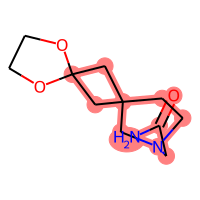
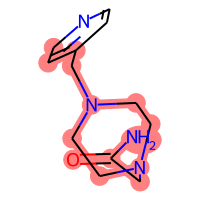
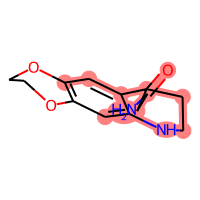
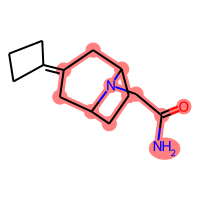
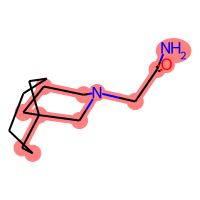

In [4]:
df.head()

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded,Fragment A protein file,Fragment B protein file
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCN(Cc2ccncc2)CC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CC1CCNc2cc3c(cc21)OCCO3,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C2CCC1CC(=C1CCC1)C2,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCCC2(CCCCCC2)C1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...

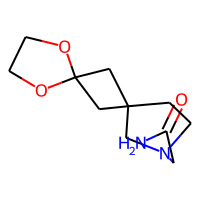
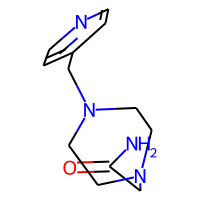
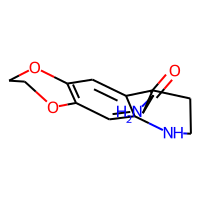
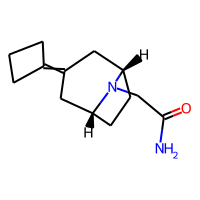
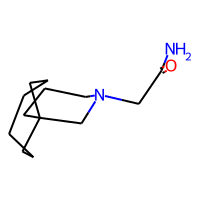

In [5]:
# replace embedded column with mols from sdf file as distance calculation doesn't work otherwise
suppl = Chem.SDMolSupplier('/home/sabsr3/xchem/fragment_network_merges/data/filtered/embeddedMols.sdf')
mols = [x for x in suppl]
df['Embedded'] = mols
df.head()

Exploring different thresholds

In [6]:
fraga_files = df['Fragment A file'].unique().tolist()
fragb_files = df['Fragment B file'].unique().tolist()
fraga_protein_files = df['Fragment A protein file'].unique().tolist()
fragb_protein_files = df['Fragment B protein file'].unique().tolist()
# embedded mols = mols

In [7]:
# convert mol filenames to mols
fraga_mols = []
fragb_mols = []

for f in fraga_files:
    for mol in Chem.SDMolSupplier(f):
        fraga_mols.append(mol)


for f in fragb_files:
    for mol in Chem.SDMolSupplier(f):
        fragb_mols.append(mol)

In [8]:
frag_distances = []

for frag, prot in zip(fraga_files, fraga_protein_files):
    mol = []
    for m in Chem.SDMolSupplier(frag):
        mol.append(m)
    dist = rdShapeHelpers.ShapeProtrudeDist(mol[0], rdmolfiles.MolFromPDBFile(prot))
    frag_distances.append(dist)


for frag, prot in zip(fragb_files, fragb_protein_files):
    mol = []
    for m in Chem.SDMolSupplier(frag):
        mol.append(m)
    dist = rdShapeHelpers.ShapeProtrudeDist(mol[0], rdmolfiles.MolFromPDBFile(prot))
    frag_distances.append(dist)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 15.]),
 array([0.85914376, 0.87272492, 0.88630607, 0.89988722, 0.91346837,
        0.92704952, 0.94063068, 0.95421183, 0.96779298, 0.98137413,
        0.99495529]),
 <BarContainer object of 10 artists>)

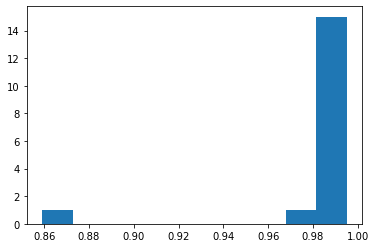

In [9]:
plt.hist(frag_distances)

It is only x1382 that has a large overlap with the protein (and this fragment should probably be avoided anyway)
The rest all have overlap <3%

In [10]:
all_frag_files = fraga_files + fragb_files
all_protein_files = fraga_protein_files + fragb_protein_files

Calculate the distance between all fragments and all protein files

In [11]:
import itertools

In [12]:
combinations = list(itertools.product(all_frag_files, all_protein_files))
len(combinations)

289

In [13]:
all_possible_distances = []
for c in combinations:
    mol = []
    for m in Chem.SDMolSupplier(c[0]):
        mol.append(m)
    dist = rdShapeHelpers.ShapeProtrudeDist(mol[0], rdmolfiles.MolFromPDBFile(c[1]))
    all_possible_distances.append(dist)

(array([  1.,   4.,  12.,  12.,  15.,   9.,   9.,  19.,  78., 130.]),
 array([0.81159037, 0.82992686, 0.84826335, 0.86659984, 0.88493633,
        0.90327283, 0.92160932, 0.93994581, 0.9582823 , 0.97661879,
        0.99495529]),
 <BarContainer object of 10 artists>)

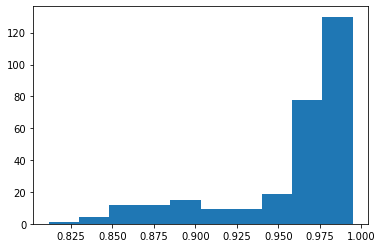

In [14]:
plt.hist(all_possible_distances)

Get just the geometric mean and plot of the merge with the two proteins and plot

In [15]:
distances = OverlapFilterDf(df).fixed_cutoff_filter()

6097it [06:37, 15.34it/s]


(array([   4.,   11.,   38.,  137.,  295.,  589., 1019., 1501., 1933.,
         570.]),
 array([0.44644503, 0.50097179, 0.55549855, 0.61002531, 0.66455208,
        0.71907884, 0.7736056 , 0.82813237, 0.88265913, 0.93718589,
        0.99171265]),
 <BarContainer object of 10 artists>)

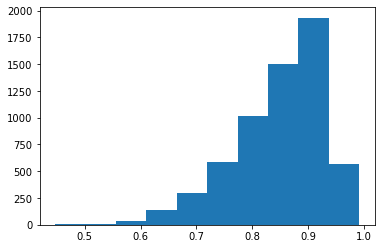

In [16]:
plt.hist(distances)

In [27]:
thresholds = [0.85, 0.875, 0.9, 0.925, 0.95, 0.975]

for t in thresholds:
    count = 0
    for i in distances:
        if i >= t: count += 1
    print(f'Number of compounds above threshold {t}: {count}')
    print(f'Proportion: {round(count / len(distances), 3)}')

Number of compounds above threshold 0.85: 3448
Proportion: 0.566
Number of compounds above threshold 0.875: 2726
Proportion: 0.447
Number of compounds above threshold 0.9: 1913
Proportion: 0.314
Number of compounds above threshold 0.925: 979
Proportion: 0.161
Number of compounds above threshold 0.95: 299
Proportion: 0.049
Number of compounds above threshold 0.975: 44
Proportion: 0.007


Will use a 5% threshold for now

I think this step will work better for other datasets - in this test set the many compounds overlap with protein for x107 which is used a lot as fragment A in the pairs - other datasets will be more balanced.

## Filter

In [7]:
filtered = OverlapFilterDf(df).fixed_cutoff_filter()

6097it [08:32, 11.89it/s]Number of molecules: 299



,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded,Fragment A protein file,Fragment B protein file
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,[Xe]C1CCCCC1,Cc1ccncc1NC(C)C1CCCCC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1,x0305_x2569t,x0305,CCNc1ccc(C#N)cn1,x2569,NC(=O)Cc1cccnc1,[Xe]c1cccnc1,CC(C)(CNC(=O)C(=O)O)c1cccnc1,x2569,N#Cc1cncc(CC(=O)Nc2cccnc2)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
2,x0107_x2572t,x0107,CC(=O)Nc1cnccc1C,x2572,N#Cc1cccc(CC(N)=O)c1,[Xe]c1ccccc1,CCOC(=O)c1cnccc1Cc1ccccc1,x2572,Cc1ccncc1NC(=O)Cc1cccc(C#N)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
3,x0434_x2608t,x0434,O=C(Nc1ccccc1)Nc1cccnc1,x2608,Cc1ccc(NC(N)=O)s1,C[Xe],CCC(Nc1cccnc1)c1ccc(C)cc1,x2608,Cc1ccc(NC(=O)Nc2cccnc2)s1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
4,x0434_x2608t,x0434,O=C(Nc1ccccc1)Nc1cccnc1,x2608,Cc1ccc(NC(N)=O)s1,C[Xe],CC(=CC(=O)c1ccc(C)cc1)NCc1cccnc1,x2608,Cc1ccc(NC(=O)Nc2cccnc2)s1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,Cl[Xe],Cc1c(Cl)cncc1C(=O)NNC(=O)OC(C)(C)C,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
295,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,Cl[Xe],Cc1c(Cl)cncc1NC(=N)NCC(C)C,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
296,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,Cl[Xe],Cc1c(Cl)cncc1NC(=N)NC(C)(C)C,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
297,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,Cl[Xe],Clc1cnccc1CN1CCCC2(CCCCCC2)C1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...

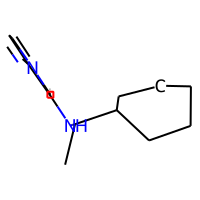
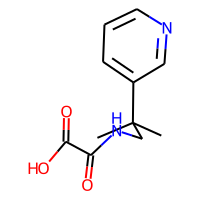
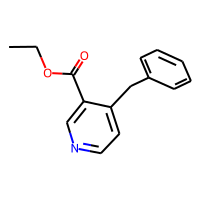
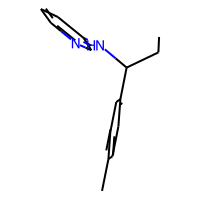
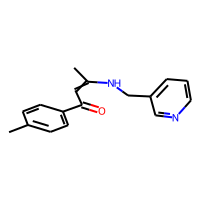
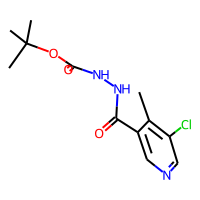
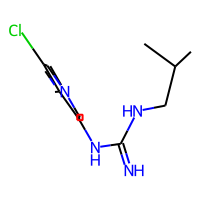
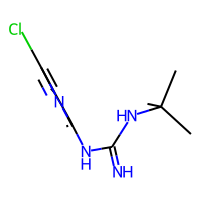
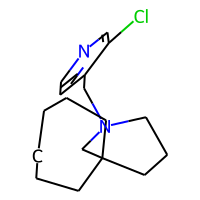
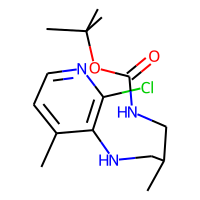

In [9]:
filtered

## Save

In [10]:
filtered.to_csv('/home/sabsr3/xchem/fragment_network_merges/data/filtered/overlapFiltered.csv', index=False)

In [12]:
# save embedded molecules (just in case) to sdf file
nonoverlap_mols = [i for i in filtered['Embedded']]

In [13]:
writer = rdmolfiles.SDWriter('/home/sabsr3/xchem/fragment_network_merges/data/filtered/nonoverlapMols.sdf')
for mol in nonoverlap_mols:
    writer.write(mol)

## Analyse the filtered molecules thus far

Calculate the tanimoto of the filtered molecules with the target smiles (allow comparison with the same metric for the entire dataset before any filtering)

In [22]:
def calc_tanimoto(targets, merges):
    """
    Calculate the tanimoto between the target molecule and all expansions.
    Return the results as a list.
    """
    tanimoto = []
    for t, m in zip(targets, merges):
        t_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(t), 2, nBits=1024)
        m_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), 2, nBits=1024)
        tani = DataStructs.FingerprintSimilarity(t_fp, m_fp, metric=DataStructs.DiceSimilarity)
        tanimoto.append(tani)

    return tanimoto

In [23]:
smiles = [i for i in filtered['Smiles']]
target_smiles = [i for i in filtered['Target smiles']]

tanimotos = calc_tanimoto(target_smiles, smiles)

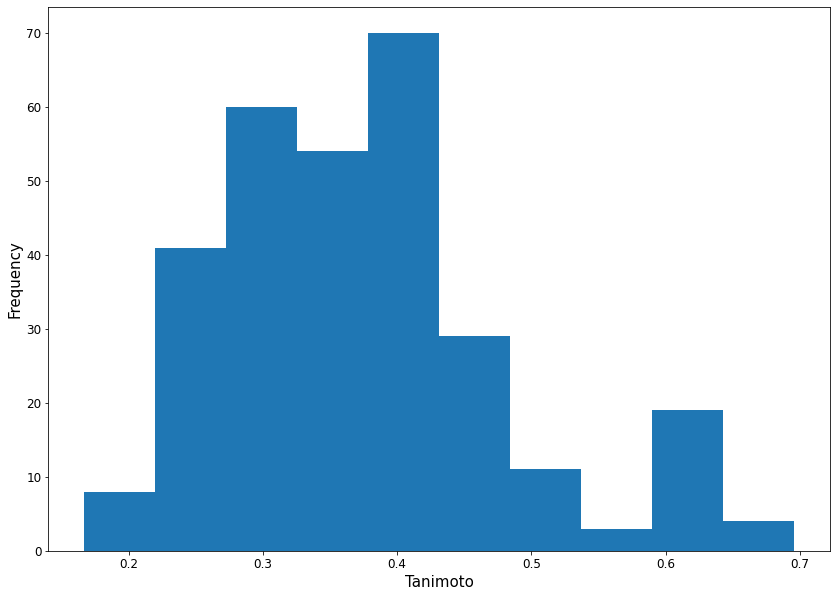

In [27]:
plt.figure(figsize=(14, 10))
plt.hist(tanimotos)
plt.xlabel('Tanimoto', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [28]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for t in thresholds:
    count = 0
    for tan in tanimotos:
        if tan >= t:
            count += 1
    perc = round(count / len(tanimotos) * 100, 2)
    print(f"Percentage of compounds wit Tanimoto {t}: {perc}%")

print('')
print(f"Total number of compounds: {len(tanimotos)}")

Percentage of compounds wit Tanimoto 0.5: 11.37%
Percentage of compounds wit Tanimoto 0.6: 5.69%
Percentage of compounds wit Tanimoto 0.7: 0.0%
Percentage of compounds wit Tanimoto 0.8: 0.0%
Percentage of compounds wit Tanimoto 0.9: 0.0%

Total number of compounds: 299


Compared with the entire dataset, there is a similar number of compounds with Tanimoto > 0.5 (10.44% for entire dataset)
There are no compounds with Tanimoto >0.7 (compared to the target smiles)